# Exploration of Koh et al. 2014 data
---

*By Joseph Marcus*

Here I explore cell-free RNA data generated by Koh et al. 2014. Paticuarly I downloaded RNA-seq count matricies from `recount2` for both the Koh et al. study as well as GTEx. Here I perform 3 experiments ...

* Run an admixture model (for many values of K) on only the cell-free RNA dataset to reveal the general structure within the Koh et al. data *[done]*

* Run an admixture model (for many values K) on the cell-free RNA dataset with the Koh et al. data merged with the GTEx project to see if we can observe a signature of particular tissues within the cell-free RNA. *[in progress]*

* Run an admixture model (for many values of K) on the GTEx project and then project the cell-free RNA samples onto the structure existing amongst the tissues samples in the GTEx consortium. This is similar to matrix factorization approaches previously performed in a few different studies but within the admixture model framework (which is novel). *[in progress]*

# Imports / configuration

library imports ...

In [22]:
suppressMessages(library(readr))
suppressMessages(library(dplyr))

suppressMessages(library(SummarizedExperiment))
suppressMessages(library(mygene))
suppressMessages(library(maptpx))
suppressMessages(library(CountClust))

plot size configuration ...

In [23]:
options(repr.plot.width=5, repr.plot.height=4)

# Data exploration

## File paths

This is the base path name to GTEx reference data and cfRNA data from Koh et al. 2014

In [24]:
mod_cfrna_path <- '/project/jnovembre/data/external_public/mod_cfrna'
gom_path <- '/project/jnovembre/data/external_public/mod_cfrna/koh_et_al_2014/koh_et_al_FitGoM.rda'
gtex_gom_path <- '/project/jnovembre/data/external_public/mod_cfrna/koh_et_al_2014/gtex_FitGoM.rda'
meta_path <- '/project/jnovembre/data/external_public/mod_cfrna/koh_et_al_2014/koh_et_al_covariates.csv' 

## Meta data

In [25]:
meta_df <- read.table(meta_path, sep=',', header=TRUE)
head(meta_df)

id,run_id,iid,label
SRX550521,SRR1296083,Control 4,Not pregnant
SRX550520,SRR1296082,Control 3,Not pregnant
SRX550519,SRR1296081,Control 2,Not pregnant
SRX550518,SRR1296080,Control 1,Not pregnant
SRX550500,SRR1296062,Patient 36,Trimester 3
SRX550493,SRR1296055,Patient 32,Post-Partum


## Gene ids

Lets get the gene ids from the recount data ...

In [26]:
rse_genes_obj <- load(paste0(mod_cfrna_path, '/koh_et_al_2014/rse_gene.Rdata'))
rse_genes <- get(rse_genes_obj)
rowRanges(rse_genes)

GRanges object with 58037 ranges and 3 metadata columns:
                     seqnames                 ranges strand |
                        <Rle>              <IRanges>  <Rle> |
  ENSG00000000003.14     chrX [100627109, 100639991]      - |
   ENSG00000000005.5     chrX [100584802, 100599885]      + |
  ENSG00000000419.12    chr20 [ 50934867,  50958555]      - |
  ENSG00000000457.13     chr1 [169849631, 169894267]      - |
  ENSG00000000460.16     chr1 [169662007, 169854080]      + |
                 ...      ...                    ...    ... .
   ENSG00000283695.1    chr19 [ 52865369,  52865429]      - |
   ENSG00000283696.1     chr1 [161399409, 161422424]      + |
   ENSG00000283697.1     chrX [149548210, 149549852]      - |
   ENSG00000283698.1     chr2 [112439312, 112469687]      - |
   ENSG00000283699.1    chr10 [ 12653138,  12653197]      - |
                                gene_id bp_length          symbol
                            <character> <integer> <CharacterList>
  ENS

In [27]:
recount_genes <- gsub('\\..*', '', rowRanges(rse_gene)$gene_id)
head(recount_genes)
length(recount_genes)

[1] "ENSG00000000003" "ENSG00000000005" "ENSG00000000419" "ENSG00000000457"
[5] "ENSG00000000460" "ENSG00000000938"

[1] 58037

Now lets get the set of genes ids used in Dey et al. 2017 ...

In [28]:
gtex_fil_genes <- read.table(paste0(mod_cfrna_path, '/gtex/gene_names_GTEX_V6.txt'), 
                             header=TRUE, stringsAsFactors=FALSE)$cis_gene_names
gtex_fil_genes <- gsub('\\..*', '', gtex_fil_genes)
head(gtex_fil_genes)
length(gtex_fil_genes)

[1] "ENSG00000000419" "ENSG00000000457" "ENSG00000000460" "ENSG00000000938"
[5] "ENSG00000000971" "ENSG00000001036"

[1] 16069

## RNA-seq data

Lets read in the data from the recount2 `.tsv` file ...

In [29]:
count_mat <- as.matrix(read_tsv(paste0(mod_cfrna_path, '/koh_et_al_2014/counts_gene.tsv')))
rownames(count_mat) <- recount_genes
dim(count_mat)

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3 parsing failures.
row # A tibble: 3 x 5 col     row        col               expected     actual expected   <int>      <chr>                  <chr>      <chr> actual 1  4198 SRR1296079 no trailing characters       e+05 file 2  5070 SRR1296063 no trailing characters       e+05 row 3 21484 SRR1296067             an integer 2322418127 col # ... with 1 more variables: file <chr>
”

[1] 58037    48

Lets keep only the genes that are in the filtered set defined by Dey et al. 2017

In [30]:
count_mat <- count_mat[rownames(count_mat) %in% gtex_fil_genes, ]
dim(count_mat)

[1] 15592    48

there seems to be 477 missing genes defined in GTEX in the recount set (TODO look into why this is the case???)

## QC

distribution of mean expression levels per gene ...

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”

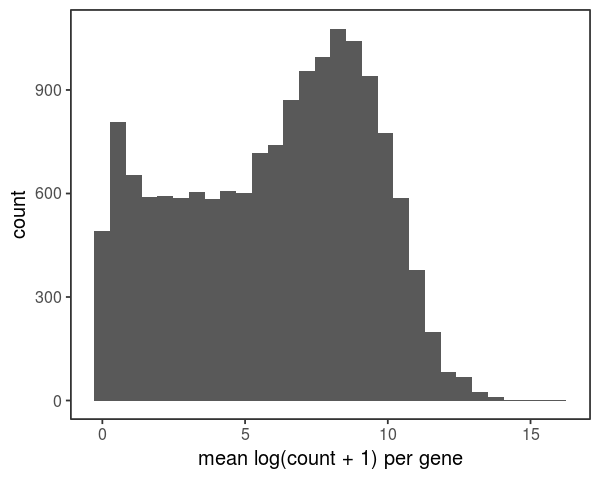

In [31]:
qplot(rowMeans(log(count_mat+1)), 
      geom='histogram', 
      xlab='mean log(count + 1) per gene')

distribution of number of expressed genes per individual ...

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”

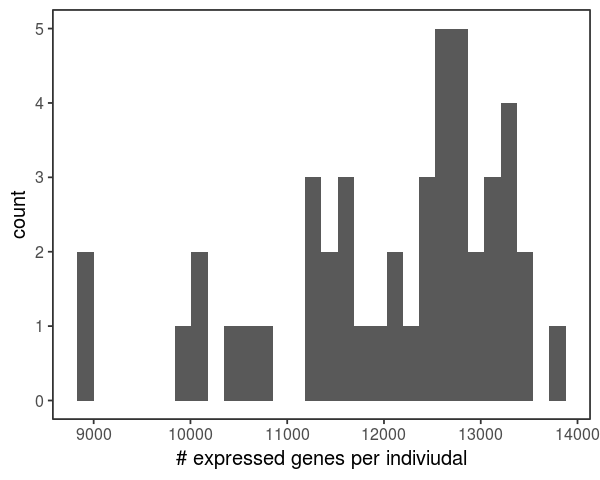

In [32]:
qplot(colSums(count_mat != 0), 
      geom='histogram', 
      xlab='# expressed genes per indiviudal')

remove rows (genes) with all missing data (i.e. all zeros) ...

In [33]:
count_mat <- count_mat[which(rowSums(count_mat) > 0),] 
dim(count_mat)

[1] 15509    48

this removed 83 genes

## PCA 

In [34]:
id_df <- data.frame(run_id=colnames(count_mat)) %>% 
         inner_join(meta_df, by=c('run_id'))
head(id_df)
head(colnames(count_mat))

run_id,id,iid,label
SRR1296036,SRX544923,Patient 2,Trimester 1
SRR1296037,SRX544924,Patient 2,Trimester 2
SRR1296039,SRX550477,Patient 2,Post-Partum
SRR1296038,SRX550476,Patient 2,Trimester 3
SRR1296040,SRX550478,Patient 15,Trimester 1
SRR1296041,SRX550479,Patient 15,Trimester 2


[1] "SRR1296036" "SRR1296037" "SRR1296039" "SRR1296038" "SRR1296040"
[6] "SRR1296041"

In [35]:
pc_res <- prcomp(t(count_mat), scale=TRUE, center=TRUE)
pc_res <- summary(pc_res)
pve <- pc_res$importance['Proportion of Variance',]
pc_labels <- paste0('PC', 1:nrow(pc_res$x), ' (', round(pve, 3) * 100, '%)')

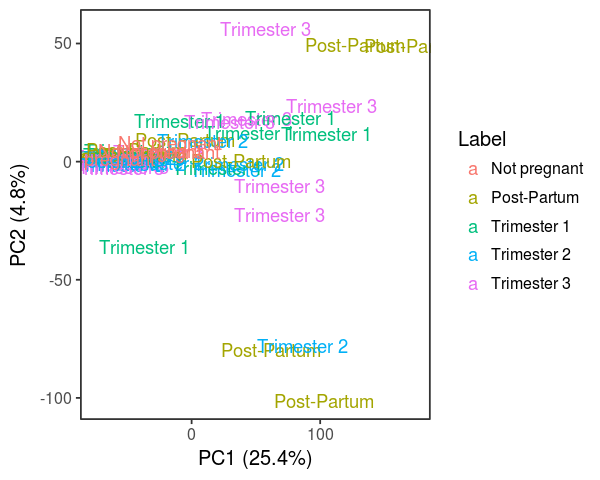

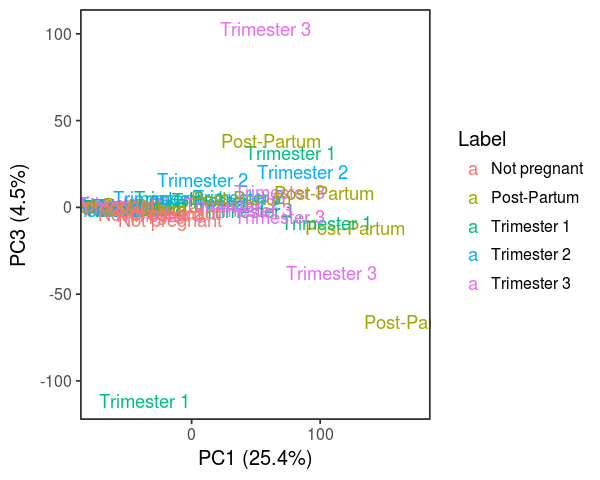

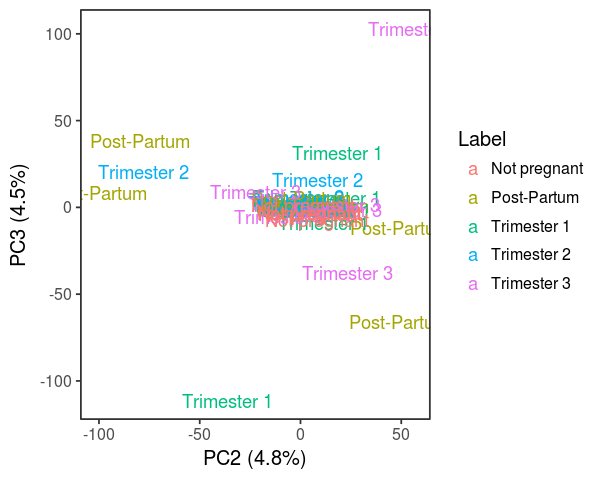

In [36]:
# pc1 vs pc2
qplot(pc_res$x[,1], pc_res$x[,2], geom='text', label=id_df$label, 
      xlab=pc_labels[1], ylab=pc_labels[2], 
      color=factor(id_df$label)) + 
labs(color='Label') 

# pc1 vs pc3
qplot(pc_res$x[,1], pc_res$x[,3], geom='text', label=id_df$label, 
      xlab=pc_labels[1], ylab=pc_labels[3], 
      color=factor(id_df$label)) + 
labs(color='Label')

# pc2 vs pc3
qplot(pc_res$x[,2], pc_res$x[,3], geom='text', label=id_df$label, 
      xlab=pc_labels[2], ylab=pc_labels[3],
      color=factor(id_df$label)) + 
labs(color='Label')

There doesn't seem to be any obivious structure in the pcs

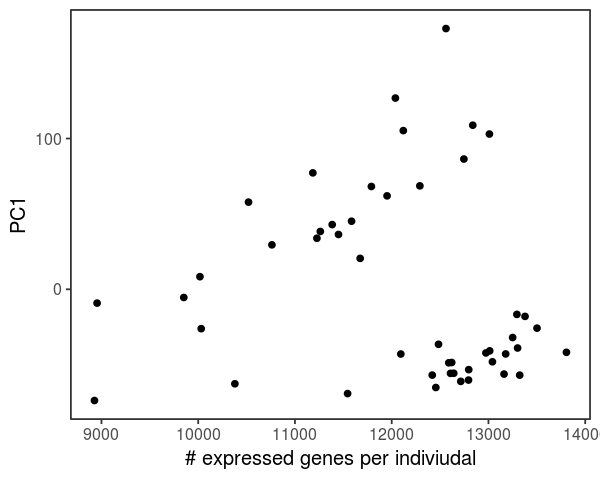

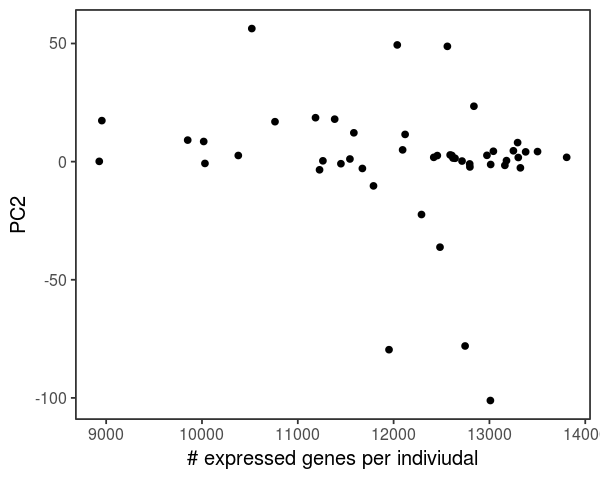

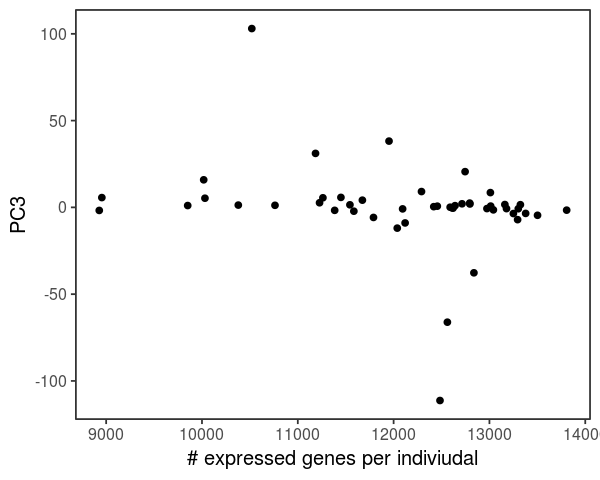

In [37]:
qplot(colSums(count_mat != 0), pc_res$x[,1], xlab='# expressed genes per indiviudal', ylab='PC1')
qplot(colSums(count_mat != 0), pc_res$x[,2], xlab='# expressed genes per indiviudal', ylab='PC2')
qplot(colSums(count_mat != 0), pc_res$x[,3], xlab='# expressed genes per indiviudal', ylab='PC3')

the pcs don't seem to be correlated with techinal expression patterns in each indiviudal

# Topic model experiments

## Experiment 1

In [38]:
if(!file.exists(gom_path)){
    FitGoM(t(count_mat), K=c(2,3,4,5,6,7,8), tol=0.1, path_rda=gom_path)   
} else {
    gom_res <- load(file=gom_path)
    gom <- get(gom_res)
}

Warning message:
“Column `run_id` joining character vector and factor, coercing into character vector”Warning message:
“Column `run_id` joining character vector and factor, coercing into character vector”Warning message:
“Column `run_id` joining character vector and factor, coercing into character vector”

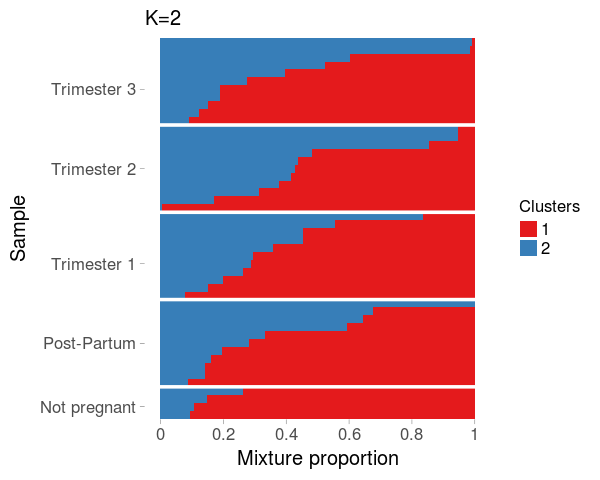

Warning message:
“Column `run_id` joining character vector and factor, coercing into character vector”

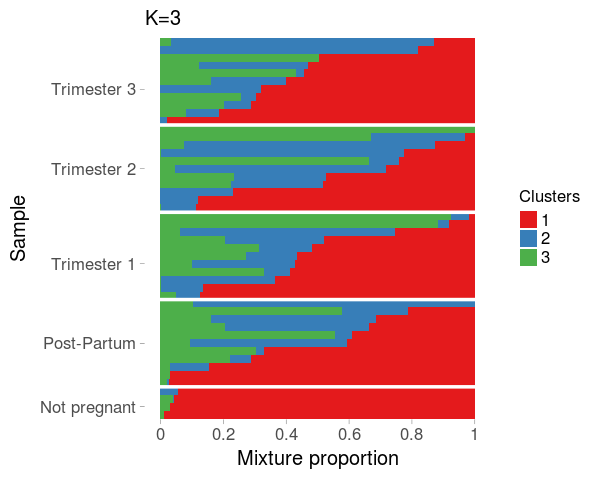

Warning message:
“Column `run_id` joining character vector and factor, coercing into character vector”

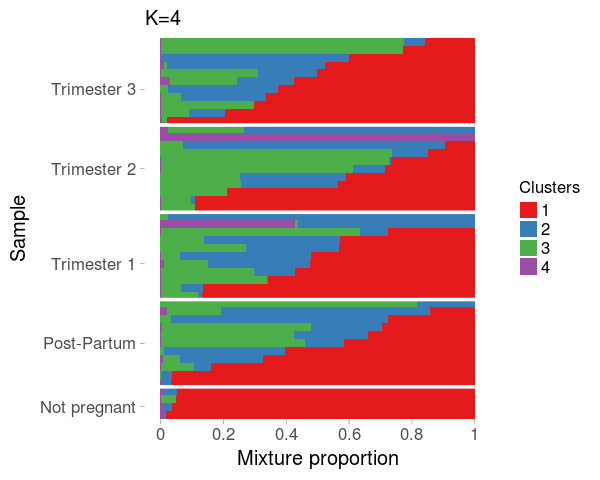

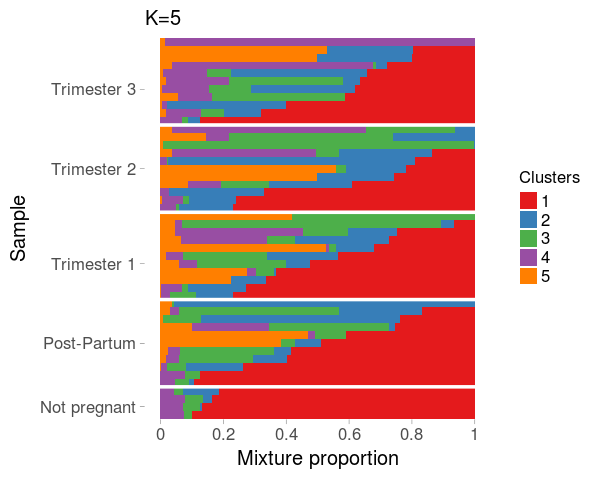

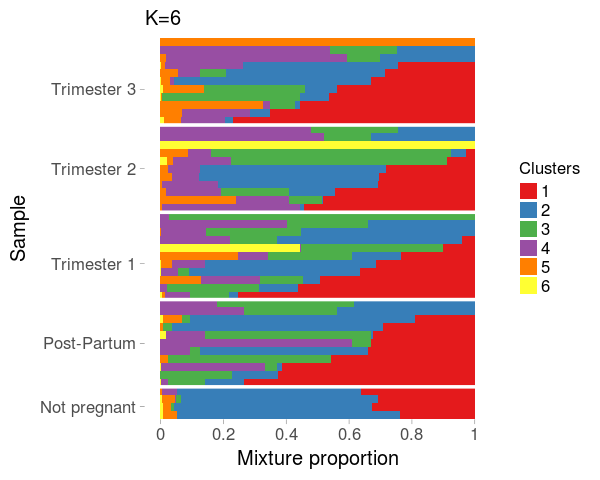

In [39]:
for(k in 2:6){

    # omega
    clust <- paste0('clust_', k)
    omega <- gom[[clust]]$omega
    omega_df <- as.data.frame(omega)
    omega_df$run_id <- rownames(omega)
    omega_df <- omega_df %>% inner_join(meta_df, by=c('run_id'))
    
    # annotate
    annotation <- data.frame(sample_id=paste0(omega_df$run_id),
                             tissue_label=factor(omega_df$label))
    colnames(omega) <- 1:ncol(omega) 
    
    #############################################################
    
    # plot
    p <- StructureGGplot(omega = omega,
                         figure_title = paste0('K=', k),
                         annotation = annotation,
                         palette = RColorBrewer::brewer.pal(8, 'Set1'),
                         yaxis_label = 'Sample',
                         order_sample = TRUE,
                         axis_tick = list(axis_ticks_length = .1,
                                          axis_ticks_lwd_y = .1,
                                          axis_ticks_lwd_x = .1
                                          )) +
         theme(
               axis.title.y=element_text(size=12),
               axis.text.y =element_text(size=10),
               axis.title.x=element_text(size=12),
               axis.text.x =element_text(size=10),
               legend.title=element_text(size=10),
               legend.text=element_text(size=10),
               plot.title = element_text(size=12)
              ) +
         ylab('Mixture proportion') 
    
    print(p)
}

Explore gene-sets driving each cluster. Lets start with the genes the drive each cluster for K=6 ...

In [40]:
K <- 6
theta_mat <- gom$clust_6$theta
top_features <- ExtractTopFeatures(theta_mat, top_features=20, 
                                   method='poisson', options='min');
gene_list <- do.call(rbind, 
                     lapply(1:dim(top_features)[1], 
                            function(x) rownames(count_mat)[top_features[x,]]))

for(k in 1:K){
    print("")
    print(paste0('--------------', 'K=', k, '--------------'))
    print("")
    gene_df <- queryMany(gene_list[k,],  scopes='ensembl.gene', 
                         fields=c('name', 'summary', 'symbol'), 
                         species='human')        
    
    print(knitr::kable(gene_df[,c('query', 'symbol', 'name')]))
    #write(gene_df[,'symbol'], file =paste0('K.', k, '.txt'))
}

[1] ""
[1] "--------------K=1--------------"
[1] ""
Finished


|query           |symbol   |name                                                      |
|:---------------|:--------|:---------------------------------------------------------|
|ENSG00000102837 |OLFM4    |olfactomedin 4                                            |
|ENSG00000164985 |PSIP1    |PC4 and SFRS1 interacting protein 1                       |
|ENSG00000113648 |H2AFY    |H2A histone family member Y                               |
|ENSG00000113282 |CLINT1   |clathrin interactor 1                                     |
|ENSG00000134186 |PRPF38B  |pre-mRNA processing factor 38B                            |
|ENSG00000163798 |SLC4A1AP |solute carrier family 4 member 1 adaptor protein          |
|ENSG00000117523 |PRRC2C   |proline rich coiled-coil 2C                               |
|ENSG00000132341 |RAN      |RAN, member RAS oncogene family                           |
|ENSG00000121671 |CRY2     |cryptochrome circadian clock 

## Experiment 3

Run strucutre on GTEX data!

In [41]:
if(!file.exists(gtex_gom_path)){
    # read and format gtex rna-seq data (this takes a bit of time) ...
    gtex_count_mat <- as.matrix(read_tsv(paste0(mod_cfrna_path, '/gtex/counts_gene.tsv')))
    
    # rename the genes
    rownames(gtex_count_mat) <- recount_genes

    # lets only look at the filtered genes we used to fit the last topic model ...
    gtex_count_mat <- gtex_count_mat[rownames(gtex_count_mat) %in% rownames(count_mat), ]

    #FitGoM(t(gtex_count_mat), K=c(10, 15, 20), tol=0.1, path_rda=gtex_gom_path) 
} else {
    load(file=gtex_gom_path)
}

Parsed with column specification:
cols(
  .default = col_integer(),
  SRR1499040 = col_double(),
  SRR1352129 = col_double(),
  SRR1096782 = col_double(),
  SRR1088365 = col_double(),
  SRR1312024 = col_double(),
  SRR1337585 = col_double(),
  SRR1394253 = col_double(),
  SRR1335875 = col_double(),
  SRR1096616 = col_double(),
  SRR1096851 = col_double(),
  SRR1455127 = col_double(),
  SRR1381590 = col_double(),
  SRR1332275 = col_double(),
  SRR602058 = col_double(),
  SRR1070937 = col_double(),
  SRR1090650 = col_double(),
  SRR1095627 = col_double(),
  SRR814633 = col_double(),
  SRR1384163 = col_double(),
  SRR1430507 = col_double()
  # ... with 43 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1003 parsing failures.
row # A tibble: 5 x 5 col     row        col               expected actual expected   <int>      <chr>              

In [44]:
FitGoM(t(gtex_count_mat), K=c(20), tol=0.1, path_rda=gtex_gom_path) 

Fitting the topic model (due to Matt Taddy)


ERROR: Error in if (sum(empty) != 0) {: missing value where TRUE/FALSE needed


In [46]:
dim(t(gtex_count_mat))

[1]  9662 15509

In [47]:
sum(is.na(gtex_count_mat))


[1] 836